# CNN: Detección de Neumonía a partir de imágenes de rayos X
## Grad-CAM

[Joel Ricci López](http://joelriccilopez.com/), 2021.

Abrir este notebook en Colab:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jRicciL/Aprendizaje_profundo_tareas_CICESE/blob/master/ConvNets_and_GradCAM_Xray_dataset/3_GradCAM_ConvNet_Explainability.ipynb)

***
<br>

## Planteamiento
*Implementaremos el método de visualización [Grad-CAM](https://keras.io/examples/vision/grad_cam/) utilizando la red neuronal convolucional previamente implementada en el notebook [`2_ConvolutionalNN_PNEUMONIA_X_ray`](ttps://colab.research.google.com/github/jRicciL/Aprendizaje_profundo_tareas_CICESE/blob/master/ConvNets_and_GradCAM_Xray_dataset/2_ConvolutionalNN_PNEUMONIA_X_ray.ipynb).*

<br>

## Estrategia de Solución
1. Se utilizará la red convolucional entrenada previamente. Acceso al notebook de la tarea anterior: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jRicciL/Aprendizaje_profundo_tareas_CICESE/blob/master/ConvNets_and_GradCAM_Xray_dataset/2_ConvolutionalNN_PNEUMONIA_X_ray.ipynb)
2. Se usarán imágenes de ejemplo del conjunto de prueba.
3. Se mostrará paso a paso la implementación del Grad-CAM.
4. Se muestran imágenes de ejemplo con sus respectivos mapas de activación.

### Montamos el acceso a Drive
Tendremos acceso a la base de datos con las imágenes así como a los modelos generados en el notebook anterior:



In [1]:
from google.colab import drive

drive.mount('/content/gdrive/')
root_path = '/content/gdrive/My Drive/kaggle/ap-jrl-neumonia/chest_xray'
%cd $root_path/
%ls

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/gdrive/My Drive/kaggle/ap-jrl-neumonia/chest_xray
chest_xray/                modelo_neu_jrl.h5                      output.png
history_cnn.pkl            modelo_neu_jrl_TRAINED.h5              test/
history_cnn_vgg16.pkl      modelo_vgg16_jrl.h5                    train/
__MACOSX/                  modelo_VGG16_jrl_trained_20_epocas.h5  val/
modelo_cnn_jrl_TRAINED.h5  modelo_vgg16_jrl_TRAINED.h5


In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from skimage.transform import resize
import numpy as np
import os
from IPython.display import display, Markdown


In [3]:
%%capture
# Instala la librería visualkeras que permite visualizar la arquitectura de la red
!pip install git+https://github.com/paulgavrikov/visualkeras

### Cargamos el modelo preentrenado

Acceso al notebook anterior:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jRicciL/Aprendizaje_profundo_tareas_CICESE/blob/master/Tarea_3/P3_ConvolutionalNN_PNEUMONIA_X-ray.ipynb)


In [4]:
# Variables con los paths a los directorios de cada conjunto
test_dir = os.path.join(root_path, 'test')
train_dir = os.path.join(root_path, 'train')
val_dir = os.path.join(root_path, 'val')

In [5]:
model_path = f"{root_path}/modelo_cnn_jrl_TRAINED.h5"
model = keras.models.load_model(model_path)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 74, 74, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0

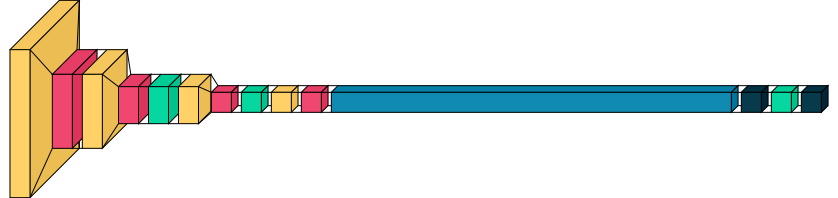

In [6]:
import visualkeras

visualkeras.layered_view(model = model, scale_xy=1)

#### Definición de las clases:

1. <font color='#fa4432'>&#11044;</font> Positivo = `PNEUMONIA`
2. <font color='#61dcad'>&#11044;</font> Negativo = `NORMAL`

In [7]:
# Definición de las clases
class_labels = {0: 'NORMAL', 1: 'PNEUMONIA'}

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Redimencionaremos las imágenes
IMG_WIDTH, IMG_HEIGHT = 150, 150
BATCH_SIZE = 32

# Prueba
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.\
            flow_from_directory(
              directory     = test_dir,
              target_size   = (IMG_WIDTH, IMG_HEIGHT),
              batch_size    = BATCH_SIZE,
              shuffle       = False,
              class_mode    = 'binary'
            )
                  

Found 584 images belonging to 2 classes.


Sólo como recordatorio, evaluamos el desempeño de la red con respecto al conjunto de entrenamiento.

In [9]:
import pickle

with open(f"{root_path}/history_cnn.pkl", 'rb') as file:
  history = pickle.load(file)

score_test = model.evaluate(test_generator)

for i, j in zip(history.keys(), score_test):
  print(f'{i.upper()}: {j:.3f}')

19/19 [==============================] - 10s 464ms/step - loss: 0.4822 - accuracy: 0.8904 - roc_auc: 0.9339 - precision: 0.8740 - recall: 0.9930
LOSS: 0.482
ACCURACY: 0.890
ROC_AUC: 0.934
PRECISION: 0.874
RECALL: 0.993


### Hagamos una predicción usando una imágen del conjunto de prueba

In [10]:
# Hagamos una predicción usando una imágen del conjunto de prueba
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_xray_image(img_path, 
               as_array = True, 
               target_size = (150, 150)
               ):
  # Carga de la imagen
  img = load_img(img_path,
                target_size = target_size)
  # Aplicamos el mismo rescaling que el generador
  # dividiendo el arreglo entre 255
  img_arr = img_to_array(img) / 255
  return img, img_arr

def make_prediciton(img_arr, model):
  img_arr = img_arr[np.newaxis,...] 
  y_pred = model.predict(img_arr)[0][0]
  clase_pred = class_labels[1] \
               if y_pred > 0.5 \
               else class_labels[0]
  return y_pred, clase_pred

In [11]:
from glob import glob

# Directorio de las imágenes de prueba
pos_test = f"{test_dir}/PNEUMONIA/*"
neg_test = f"{test_dir}/NORMAL/*"

# Lista de archivos de pruebba
pos_test_files = glob(pos_test)
neg_test_files = glob(neg_test)

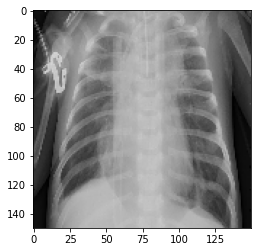

(0.99999315, 'PNEUMONIA')

In [12]:
img_path = np.random.choice(pos_test_files, size = 1)[0]

img, img_arr = load_xray_image(img_path)

plt.imshow(img)
plt.show()

make_prediciton(img_arr, model = model)

# Grad-CAM paso a paso

### Definimos los nombres de las capas de la red
Estas capas corresponden a la última capa convolutiva con los mapas de características $A$.

In [13]:
# La última capa convolucional del modelo
last_conv_layer_name = 'conv2d_3'
# Las capas usadas para la clasificación
clf_layers_name = ['max_pooling2d_3', 'flatten', 
              'dense', 'dropout_2', 'dense_1']

Ahora segmentamos el modelo en dos modelos:
1. La red convolucional
2. La red encargada de clasificar las imágenes

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 74, 74, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496 

None

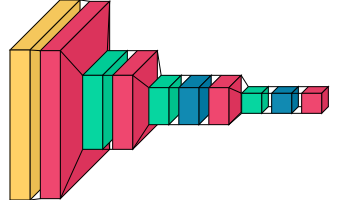

In [14]:
# Modelo convolucional
last_conv_layer = model.get_layer(last_conv_layer_name)
grad_model = keras.Model(model.inputs, last_conv_layer.output)

# Visualizamos esta parte del modelo
display(grad_model.summary())
visualkeras.layered_view(model = grad_model, scale_xy=1)

In [15]:
# Modelo classificador
# Recibe como input al feature map de la última capa convolutiva
clf_input = keras.Input(shape = last_conv_layer.output.shape[1:])
x = clf_input
for layer in clf_layers_name:
  x = model.get_layer(layer)(x)
clf_model = keras.Model(clf_input, x)

# Visualizamos esta parte del modelo
display(clf_model.summary())
visualkeras.layered_view(model = clf_model, scale_xy=1)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18, 18, 64)]      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 9, 9, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 5184)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                331840    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 331,905
Trainable params: 331,905
Non-trainable params: 0
_____________________________________________________

None

Ahora, calculamos el gradiente de $y^c$ mediante retropropagación. $y^c$ es el *score* de la clase de interés $c$ (PNEUMNIA en este ejemplo), con respecto al mapa de características $A^k$ de la última capa convolucional.

Para cada mapa de características $A^k$ calculamos:
$$\frac{\partial{y^c}}{\partial{A^k}}$$ 

In [16]:
# Daremos como entrada la imagen que visualizamos anteriormente
img_arr_ = img_arr[np.newaxis,...]

# Calculo del gradiente de la clase predicha
# (PNEUMONIA = 1) para la imagen dada como entrada
with tf.GradientTape() as tape:
  # Calcula la salida de la última capa convolucional
  last_conv_layer_output = grad_model(img_arr_)
  # print( last_conv_layer_output.shape) 
  tape.watch(last_conv_layer_output) 

  # Calcula la predicción de la clase con el modelo clasificador 
  pred = clf_model(last_conv_layer_output) # Score sin aplicar sigmoide
  display(Markdown(f"Valor $y^c$: {tf.squeeze(pred):.3E}"))
  # El valor predicho 
  top_class_channel = pred[0]

# La última convolutiva capa posee 64 filtros con dimensiones de 18x18
display(Markdown(f"Dimensiones del $A$: {last_conv_layer_output.shape}"))

# Obtenemos el gradiente de la capa final clasificadora 
# con respecto a la capa de salida del modelo convolucional
grads = tape.gradient(top_class_channel, last_conv_layer_output)

display(Markdown(
    f"Dimensiones del tensor de gradientes: {last_conv_layer_output.shape}"))

Valor $y^c$: 1.000E+00

Dimensiones del $A$: (1, 18, 18, 64)

Dimensiones del tensor de gradientes: (1, 18, 18, 64)

Ahora calculamos la agrupación promedio global de los gradientes obtenidos en cada mapa de características para obtener los pesos de importancia de cada mapa:

$$\alpha^c_k = \frac{1}{Z}\sum_i \sum_j \frac{\partial{y^c}}{\partial{A^k_{ij}}}$$

In [17]:
# Vector de pesos: medias del gradiente por capas,
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
pooled_grads.shape

TensorShape([64])

Ahora realizamos una combinación linear entre los pesos $a_k^c$  y su respectivo canal $A^k$:
$$\sum_k a_k^c A^k$$

In [18]:
# 1)
# La web de Keras propone utilizarlo de la siguiente manera,
# Mediante el operador @ para multiplicación de matrices
Aw = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
Aw = tf.squeeze(Aw) # Quitamos dimensiones demás

# 2)
# La web personal del Dr. Mariano Rivera propone
# la multiplicación recorriendo los mapas de caracteristicas (canales)

# Multiplicación a@A
Aw_1 = last_conv_layer_output[0].numpy()
for i in range(pooled_grads.shape[-1]):
    Aw_1[:, :, i] *= pooled_grads[i]
# Suma por canales
Aw_1 = np.sum(Aw_1, axis=-1)

# Comprobamos que ambas soluciones son iguales
np.allclose(Aw, Aw_1)

True

Ahora aplicamos la función ReLU a al resultado anterior para así obtener el Grad-CAM de la clase $c$:

$$L^c_{\textrm{Grad-CAM}} = ReLU\left(\sum_k a_k^c A^k \right)$$

Finalmente, normalizamos dividiendo los elementos del GradCAM entre el valor su valor máximo:

$$L^c_{\textrm{Grad-CAM}} = \frac{L^c_{\textrm{Grad-CAM}}}{\textrm{max}(L^c_{\textrm{Grad-CAM}})}$$

In [19]:
# Aplicamos ReLU 
grad_cam = tf.maximum(Aw, 0)

# Normalizamos dividiendo los elementos 
# del tensor entre el valor máximo
grad_cam = grad_cam / tf.math.reduce_max(Aw)

### Visualizamos el heatmap correspondiente al Grad-CAM

Para ello usaremos la misma imagen que dimos como entrada en el ejemplo paso a paso.

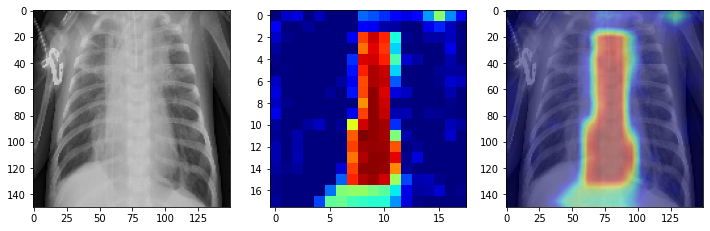

In [20]:
fig, ax = plt.subplots(1, 3, figsize = (12, 5))
upsample = resize(grad_cam, (150, 150))
ax[0].imshow(img)
ax[1].imshow(grad_cam, cmap='jet')
ax[2].imshow(img)
ax[2].imshow(upsample, alpha=0.4, cmap='jet')
plt.show()

In [33]:
#@title Aplicando a otras imágenes de ejemplo

# La última capa convolucional del modelo
last_conv_layer_name = 'conv2d_3'
# Las capas usadas para la clasificación
clf_layers_names = ['max_pooling2d_3', 'flatten', 
              'dense', 'dropout_2', 'dense_1']

def make_grad_cam(img_arr, model, last_conv_layer_name,
                  clf_layers_names):
  # Modelo convolucional
  last_conv_layer = model.get_layer(last_conv_layer_name)
  grad_model = keras.Model(model.inputs, last_conv_layer.output)

  # Modelo classificador
  clf_input = keras.Input(shape = last_conv_layer.output.shape[1:])
  x = clf_input
  for layer in clf_layers_names:
    x = model.get_layer(layer)(x)
  clf_model = keras.Model(clf_input, x)


  img_arr_ = img_arr[np.newaxis,...]

  with tf.GradientTape() as tape:
    # Calcula la salida de la última capa convolucional
    last_conv_layer_output = grad_model(img_arr_)
    tape.watch(last_conv_layer_output) 

    # Calcula la predicción de la clase con el modelo clasificador 
    pred = clf_model(last_conv_layer_output) # Score sin aplicar sigmoide
    top_class_channel = pred[0]

  grads = tape.gradient(top_class_channel, last_conv_layer_output)
  # Vector de pesos: medias del gradiente por capas,
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

  Aw = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
  Aw = tf.squeeze(Aw) 
  grad_cam = tf.maximum(Aw, 0) / tf.math.reduce_max(Aw)

  return grad_cam.numpy()


def visualize_grad_cam(img, img_arr, grad_cam, true_label,
                       cmap='jet', alpha=0.4):
  # Predicción
  pred = make_prediciton(img_arr, model = model)
  # titulo
  title = f'Real: {true_label}\nPredicho: {pred[1]} (p={pred[0]:.2f})'
  fig, ax = plt.subplots(1, 3, figsize = (12, 5))
  upsample = resize(grad_cam, (150, 150))
  ax[0].imshow(img)
  ax[1].imshow(grad_cam, cmap=cmap)
  ax[2].imshow(img)
  ax[2].imshow(upsample, alpha=alpha, cmap=cmap)
  plt.suptitle(title, fontsize=16, y = 0.9)
  plt.show()


### Ejemplos de la clase PNEUMONIA

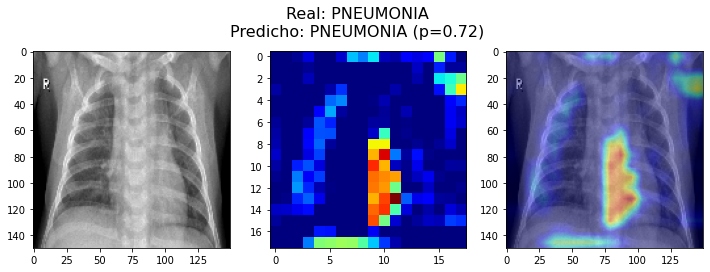

In [34]:
# Esta es la imagen del ejemplo
grad_cam = make_grad_cam(img_arr, model, last_conv_layer_name,
              clf_layers_names)

# Visualización
visualize_grad_cam(img, img_arr, grad_cam, true_label='PNEUMONIA')

Algunas imágenes elegidas aleatoriamente:

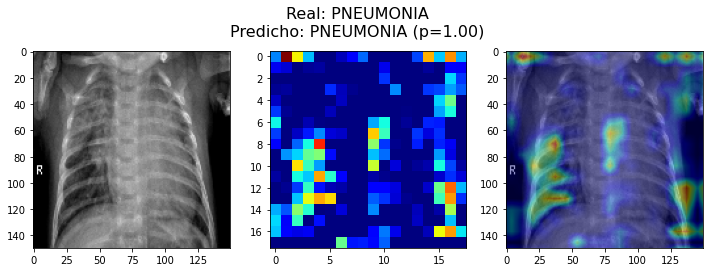

In [35]:
img_path = np.random.choice(pos_test_files, size = 1)[0]
img, img_arr = load_xray_image(img_path)
grad_cam = make_grad_cam(img_arr, model, last_conv_layer_name,
              clf_layers_names)

# Visualización
visualize_grad_cam(img, img_arr, grad_cam, true_label='PNEUMONIA')


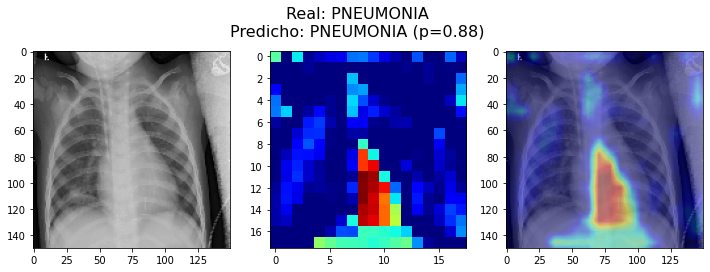

In [36]:
img_path = np.random.choice(pos_test_files, size = 1)[0]
img, img_arr = load_xray_image(img_path)
grad_cam = make_grad_cam(img_arr, model, last_conv_layer_name,
              clf_layers_names)

# Visualización
visualize_grad_cam(img, img_arr, grad_cam, true_label='PNEUMONIA')


### Imágenes de la clase NORMAL

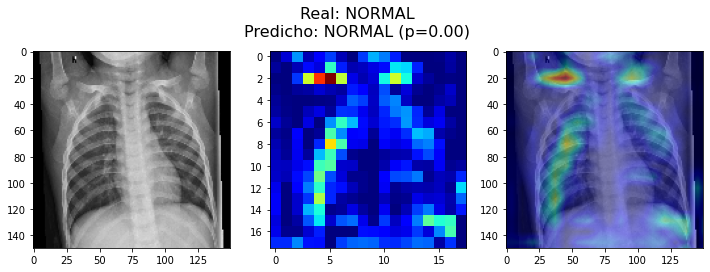

In [39]:
img_path = np.random.choice(neg_test_files, size = 1)[0]
img, img_arr = load_xray_image(img_path)
grad_cam = make_grad_cam(img_arr, model, last_conv_layer_name,
              clf_layers_names)

# Visualización
visualize_grad_cam(img, img_arr, grad_cam, true_label='NORMAL')

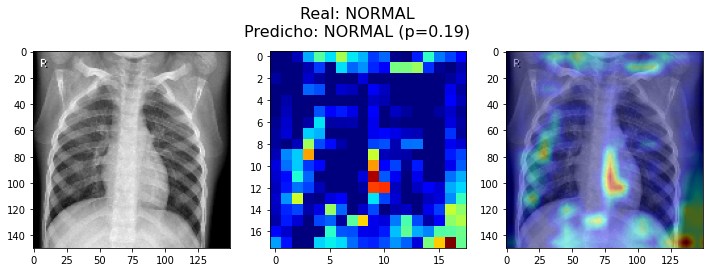

In [40]:
img_path = np.random.choice(neg_test_files, size = 1)[0]
img, img_arr = load_xray_image(img_path)
grad_cam = make_grad_cam(img_arr, model, last_conv_layer_name,
              clf_layers_names)

# Visualización
visualize_grad_cam(img, img_arr, grad_cam, true_label='NORMAL')

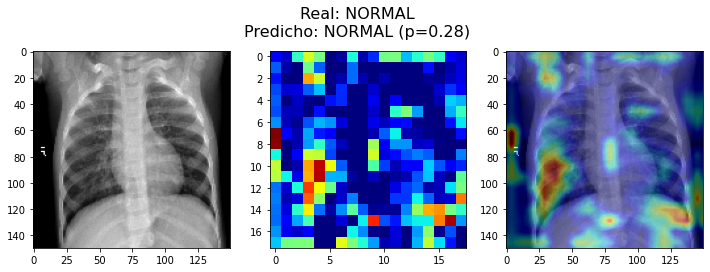

In [41]:
img_path = np.random.choice(neg_test_files, size = 1)[0]
img, img_arr = load_xray_image(img_path)
grad_cam = make_grad_cam(img_arr, model, last_conv_layer_name,
              clf_layers_names)

# Visualización
visualize_grad_cam(img, img_arr, grad_cam, true_label='NORMAL')

# Referencias

1. Mariano Rivera (2018). **[Grad-CAM: Visualizacion de mapas de activación](http://personal.cimat.mx:8181/~mrivera/cursos/aprendizaje_profundo/GradCAM/GradCAM.html)**. *Consultado el 25 de marzo del 2021.*
2. Chollet, Francois (2020). **[Grad-CAM class activation visualization](https://keras.io/examples/vision/grad_cam/)**. En keras.io. *Consultado el 26 de marzo del 2021.*
3. Paul Mooney (2018). **[Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)**. En kaggle.com. *Consultado el 18 de marzo del 2021.*
4. Selvaraju, R. R., Cogswell, M., Das, A., Vedantam, R., Parikh, D., & Batra, D. (2020). Grad-CAM: Visual Explanations from Deep Networks via Gradient-Based Localization. International Journal of Computer Vision, 128(2), 336–359. https://doi.org/10.1007/s11263-019-01228-7